In [888]:
import numpy
import requests
import pandas as pd
import time
import datetime
import json

import ijson
from pandas.io.json import json_normalize #package for flattening json in pandas df
import seaborn as sns
import matplotlib.pyplot as plt

In [895]:
# Vaisala HMP7, measuring humidity and temperature

Ceiling1 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]
Ceiling2 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]
Floor1 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]
Doorway1 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]
Outdoor1 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]
Bench2 = [
#     'Absolute humidity at NTP.value','Absolute humidity.value',
       'Relative humidity.value', 'Temperature.value',
#       'Water concentration.value'
]

# Vaisala TMP666, measuring temperature
Stove1 = ['Temperature.value',
       'Water vapor saturation pressure.value']
Stove2 = ['Temperature.value',
       'Water vapor saturation pressure.value']


# Vaisala GMP252, measuring carbon dioxide concentration
Bench1 = ['Carbon Dioxide concentration.value', 'Temperature.value']

# Vaisala OMT355, measuring oxygen concentration
Bench3 = ['Oxygen concentration.value','Temperature.value']





columns_to_use = {
    # Vaisala HMP7, measuring humidity and temperature

'Ceiling1':Ceiling1,
'Ceiling2':Ceiling1,
'Floor1' :Ceiling1,
'Doorway1':Ceiling1,
'Outdoor1': Ceiling1,
'Bench2':Ceiling1,

# Vaisala TMP666, measuring temperature
'Stove1':Stove1,
'Stove2' :Stove1,


# Vaisala GMP252, measuring carbon dioxide concentration
'Bench1': Bench1,

# Vaisala OMT355, measuring oxygen concentration
'Bench3':Bench3
    
}


In [890]:
max_timestamp = 1543084778609
devices = ['Ceiling1',  'Bench1', 'Bench2', 'Bench3', 'Floor1']

def get_historical_data(device):
    url = 'https://apigtw.vaisala.com/hackjunction2018/saunameasurements/history?SensorID={}'.format(device)
    page = requests.get(url)
    data = page.json()
#     print(device, page.headers['Measurement-Count'])
    return(data)

def convert_json_to_df(data):
    df = pd.DataFrame(data)
    return(df)

def get_historical_data_full(device, max_timestamp=1543106564890, periods=5):
    data_full = []
    for i in range(periods):
        max_timestamp_permanent = max_timestamp
        # min_permanent = max_timestamp_permanent - 1000000 * (i + 1)
        url = 'https://apigtw.vaisala.com/hackjunction2018/saunameasurements/history?SensorID={0}&before={1}'.format(
            device, max_timestamp_permanent)
        page = requests.get(url)
        data = page.json()
#         print(len(data))
        #         print(type(data))
        # max_timestamp = max_timestamp_permanent
        max_timestamp = int(page.headers['Continue-From-Here'])
        data_full.extend(data)
        time.sleep(5)
        print(len(data_full))
    #         print(page.headers)
    #         max_timestamp = int(page.headers['Continue-From-Here'])
    #     print(type(min_in_data))
    #     while min_in_data>min_timestamp:
    #         url = 'https://apigtw.vaisala.com/hackjunction2018/saunameasurements/history?SensorID={0}&before={1}'.format(device,min_in_data)
    #         page = requests.get(url)
    #         data2 = page.json()
    #         min_in_data = page.headers['Continue-From-Here']
    return (data_full)



def create_df_for_device_data(device, columns_to_use): 
#     data = get_historical_data(device)
    data = get_historical_data_full(device, max_timestamp = 1543106564890)
    df_from_json = convert_json_to_df(data)
    
#     display(df_from_json.head())
#     columns_to_use = ['Absolute humidity.value', 'Temperature.value']
    
#     df_time = pd.DataFrame(df_from_json['Timestamp'], columns = ['Timestamp'])
#     df_measurements = json_normalize(df_from_json['Measurements'])[columns_to_use[device]]
#     print(columns_to_use[device])
#     display(df_measurements[[columns_to_use[device]]].head())
    
    
    df = pd.merge(pd.DataFrame(df_from_json['Timestamp'], columns = ['Timestamp']), json_normalize(df_from_json['Measurements'])[columns_to_use[device]], left_index=True, right_index=True)
# /    display(df.head())
    df['date_time'] = df.Timestamp.apply(lambda x: datetime.datetime.fromtimestamp(int(x)/1000).strftime('%Y-%m-%d %H:%M:%S'))
    df['device']=device
    return(df.sort_values('Timestamp'))
    
# data = get_historical_data('Ceiling1')
# data

In [942]:
for device in devices:
    df2 = create_df_for_device_data(device, columns_to_use)
    df2.to_csv('{}_full.csv'.format(device), index=False)
    print(device, len(df2))

# Load data

In [943]:
# devices
# for device in devices:
#     try:
#         data = pd.read_csv("{}_full.csv".format(device))
# #         data=data.drop(['Unnamed: 0'], axis=1)
#         data
#         print(data.columns, device)
#     except:
#         continue

In [944]:
bench1 = pd.read_csv("{}_full.csv".format('Bench1'))
bench1=bench1.drop(['device'], axis=1)
bench1.columns = ['Timestamp', 'Carbon Dioxide concentration.bench1', 'Temperature.bench1', 'date_time']
# display(bench1.head())


floor1 = pd.read_csv("{}_full.csv".format('Floor1'))
floor1=floor1.drop(['device'], axis=1)
floor1.columns = ['Timestamp', 'Relative humidity.floor1', 'Temperature.floor1',
       'date_time']
# display(floor1.head())


bench3 = pd.read_csv("{}_full.csv".format('Bench3'))
bench3=bench3.drop(['device'], axis=1)
bench3.columns = ['Timestamp', 'Oxygen concentration.bench3', 'Temperature.bench3',
       'date_time']
# display(bench3.head())

bench2 = pd.read_csv("{}_full.csv".format('Bench2'))
bench2=bench2.drop(['device'], axis=1)
bench2.columns = ['Timestamp', 'Relative humidity.bench2', 'Temperature.bench2',
       'date_time']
# display(bench2.head())

ceiling1 = pd.read_csv("{}_full.csv".format('Ceiling1'))
ceiling1=ceiling1.drop(['device'], axis=1)
ceiling1.columns = ['Timestamp', 'Relative humidity.Ceiling1', 'Temperature.Ceiling1',
       'date_time']
# ceiling1.head()

In [945]:
bench1 = create_df_for_device_data('Bench1', columns_to_use)
bench1=bench1.drop(['device'], axis=1)
bench1.columns = ['Timestamp', 'Carbon Dioxide concentration.bench1', 'Temperature.bench1', 'date_time']
display(bench1.head())


floor1 = create_df_for_device_data('floor1', columns_to_use)
floor1=floor1.drop(['device'], axis=1)
floor1.columns = ['Timestamp', 'Relative humidity.floor1', 'Temperature.floor1',
       'date_time']
display(floor1.head())


bench3 = create_df_for_device_data('bench3', columns_to_use)
bench3=bench3.drop(['device'], axis=1)
bench3.columns = ['Timestamp', 'Oxygen concentration.bench3', 'Temperature.bench3',
       'date_time']
display(bench3.head())

bench2 = create_df_for_device_data('bench2', columns_to_use)
bench2=bench2.drop(['device'], axis=1)
bench2.columns = ['Timestamp', 'Relative humidity.bench2', 'Temperature.bench2',
       'date_time']
display(bench2.head())

ceiling1 = create_df_for_device_data('ceiling1', columns_to_use)
ceiling1=ceiling1.drop(['device'], axis=1)
ceiling1.columns = ['Timestamp', 'Relative humidity.Ceiling1', 'Temperature.Ceiling1',
       'date_time']
ceiling1.head()

In [894]:
bench1.shape[0], bench2.shape[0], bench3.shape[0], floor1.shape[0], ceiling1.shape[0]

(82585, 14226, 88279, 14254, 14198)

In [706]:
df = pd.merge(bench3, bench1, on='date_time', how='left')
df = pd.merge(df, floor1, on='date_time', how='left')
df = pd.merge(df, bench2, on='date_time', how='left')
df = pd.merge(df, ceiling1, on='date_time', how='left')
df.describe()

,Timestamp_x,Oxygen concentration.bench3,Temperature.bench3,Timestamp_y,Carbon Dioxide concentration.bench1,Temperature.bench1,Timestamp_x,Relative humidity.floor1,Temperature.floor1,Timestamp_y,Relative humidity.bench2,Temperature.bench2,Timestamp,Relative humidity.Ceiling1,Temperature.Ceiling1
count,9.936300e+04,99363.000000,99363.000000,8.511200e+04,85112.000000,85112.000000,2.101100e+04,21011.000000,21011.000000,1.944400e+04,19444.000000,19444.000000,1.962800e+04,19628.000000,19628.000000
mean,1.543064e+12,18.056992,51.817773,1.543066e+12,713.459559,52.449697,1.543098e+12,76.197128,29.272137,1.543099e+12,16.649169,68.204988,1.543099e+12,2.162273,107.210204
std,2.603652e+07,1.754082,20.704324,2.443267e+07,478.272431,25.468137,4.147280e+06,9.785366,6.931810,4.098769e+06,9.742558,13.282223,4.093216e+06,3.307620,21.152939
min,1.543018e+12,15.200000,12.500000,1.543024e+12,320.000000,7.690000,1.543092e+12,38.830000,7.430000,1.543093e+12,5.120000,29.420000,1.543093e+12,0.000000,47.090000
25%,1.543042e+12,16.700000,32.000000,1.543045e+12,378.000000,26.350000,1.543095e+12,70.060000,27.610000,1.543095e+12,9.340000,65.147500,1.543095e+12,0.320000,103.570000
50%,1.543065e+12,17.100000,62.700000,1.543066e+12,446.000000,66.145000,1.543098e+12,76.110000,32.200000,1.543098e+12,12.870000,73.475000,1.543098e+12,0.730000,114.530000
75%,1.543089e+12,19.800000,67.400000,1.543089e+12,931.000000,72.400000,1.543102e+12,84.300000,33.580000,1.543102e+12,23.400000,77.170000,1.543102e+12,3.110000,120.430000
max,1.543107e+12,21.300000,81.500000,1.543107e+12,3406.000000,88.780000,1.543107e+12,95.920000,36.490000,1.543107e+12,45.690000,82.820000,1.543107e+12,43.150000,130.790000


In [709]:
df_cleaned = df.dropna().sort_values('Timestamp')[['date_time', 'Timestamp', 'Oxygen concentration.bench3', 'Temperature.bench3',
       'Carbon Dioxide concentration.bench1',
       'Temperature.bench1',  'Relative humidity.floor1',
       'Temperature.floor1', 'Relative humidity.bench2',
       'Temperature.bench2', 'Relative humidity.Ceiling1',
       'Temperature.Ceiling1']]
df_cleaned=df_cleaned.set_index('date_time')
from datetime import datetime, date, time
df_cleaned['date_format'] = df_cleaned.Timestamp.apply(lambda x: datetime.fromtimestamp(x / 1e3))
df_cleaned.head()

,Timestamp,Oxygen concentration.bench3,Temperature.bench3,Carbon Dioxide concentration.bench1,Temperature.bench1,Relative humidity.floor1,Temperature.floor1,Relative humidity.bench2,Temperature.bench2,Relative humidity.Ceiling1,Temperature.Ceiling1,date_format
date_time,,,,,,,,,,,,
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.84,2018-11-24 22:53:18.072
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.84,2018-11-24 22:53:18.072
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.85,2018-11-24 22:53:18.674
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.85,2018-11-24 22:53:18.674
2018-11-24 22:53:20,1.543093e+12,16.5,66.0,684.0,70.00,89.66,34.11,12.81,77.71,0.61,123.87,2018-11-24 22:53:20.078


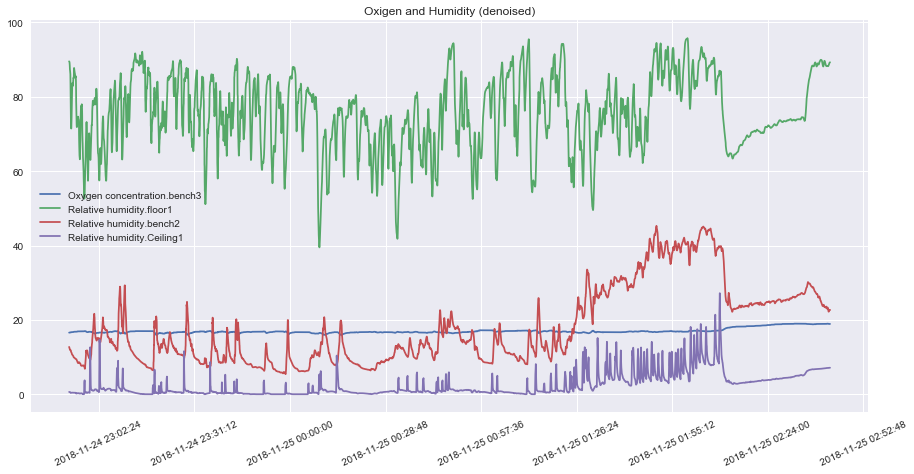

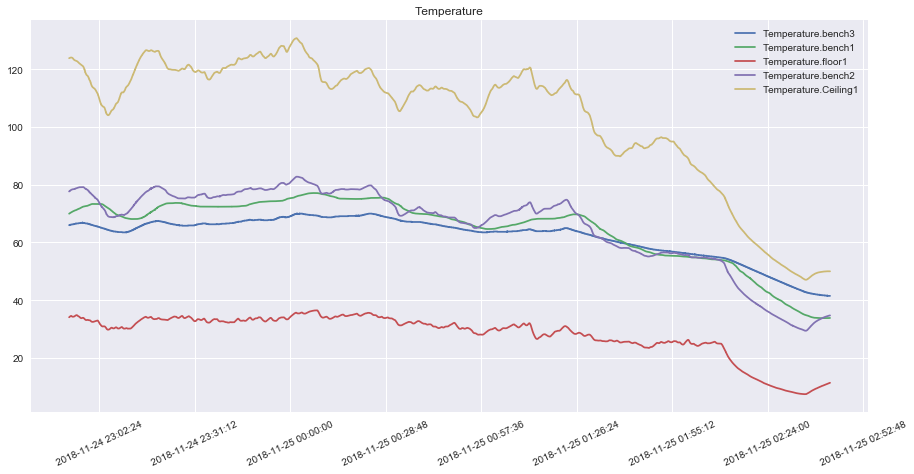

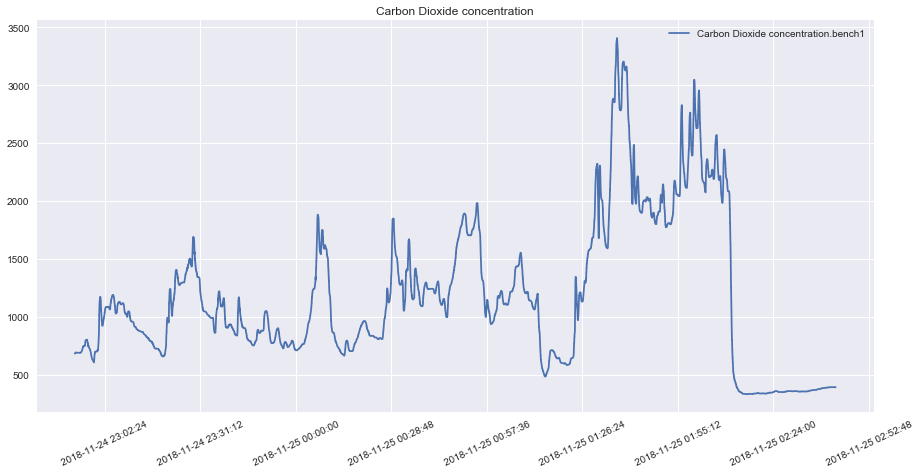

In [712]:
ax = plt.figure(figsize=(15,8))

import matplotlib.dates as md


dates=[datetime.fromtimestamp(ts) for ts in df_cleaned.Timestamp/1000]
datenums=md.date2num(dates)

for col in ['Oxygen concentration.bench3', 
#        'Carbon Dioxide concentration.bench1', 
#             'Temperature.bench1',
       'Relative humidity.floor1', 
       'Relative humidity.bench2', 
       'Relative humidity.Ceiling1']:
    values=df_cleaned[col].rolling(15).mean()
    plt.subplots_adjust(bottom=0.2)
    plt.xticks( rotation=25 )
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(datenums,values)
plt.legend()
plt.title('Oxigen and Humidity (denoised)')
plt.show()

ax = plt.figure(figsize=(15,8))

import matplotlib.dates as md


dates=[datetime.fromtimestamp(ts) for ts in df_cleaned.Timestamp/1000]
datenums=md.date2num(dates)

for col in ['Temperature.bench3',
#        'Carbon Dioxide concentration.bench1', 
            'Temperature.bench1',
        'Temperature.floor1',
'Temperature.bench2',
 'Temperature.Ceiling1']:
    values=df_cleaned[col]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks( rotation=25 )
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(datenums,values)
plt.legend()
plt.title('Temperature')
plt.show()

ax = plt.figure(figsize=(15,8))
import matplotlib.dates as md


dates=[datetime.fromtimestamp(ts) for ts in df_cleaned.Timestamp/1000]
datenums=md.date2num(dates)
values=df_cleaned['Carbon Dioxide concentration.bench1']
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums,values, label='Carbon Dioxide concentration.bench1')
plt.legend()
plt.title('Carbon Dioxide concentration')
plt.show()

# Load App data

In [946]:
events = pd.read_csv('events.csv')
events['date_time'] = events.timestamp.apply(lambda x: x[:19])
events['timestamp'] = events.date_time.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp() * 1000)
# events.head()

In [913]:
bpm = pd.read_csv('bpm.csv')
bpm['date_format'] = bpm.timestamp.apply(lambda x: x[:19])
bpm['date_time'] = bpm.timestamp.apply(lambda x: x[:19])
bpm['Timestamp'] = bpm.date_format.apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp())
bpm['date_format'] = bpm.Timestamp.apply(lambda x: datetime.fromtimestamp(x ))

bpm = bpm.set_index('date_time')

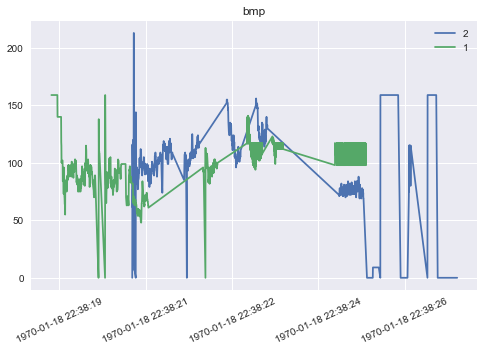

In [947]:
user_id=2
# timestamps = bmp.Timestamp.unique()
dates=[datetime.fromtimestamp(ts) for ts in bpm[bpm.user_id==user_id].Timestamp/1000]
datenums=md.date2num(dates)


values=bpm[bpm.user_id==user_id].bpm
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums,values, label=user_id)


user_id=1
# timestamps = bmp.Timestamp.unique()
dates=[datetime.fromtimestamp(ts) for ts in bpm[bpm.user_id==user_id].Timestamp/1000]
datenums=md.date2num(dates)


values=bpm[bpm.user_id==user_id].bpm
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums,values, label=user_id)

plt.legend()
plt.title('bmp')


plt.show()

In [916]:
len(timestamps)

bpm.dtypes
df_cleaned.head()

,Timestamp,Oxygen concentration.bench3,Temperature.bench3,Carbon Dioxide concentration.bench1,Temperature.bench1,Relative humidity.floor1,Temperature.floor1,Relative humidity.bench2,Temperature.bench2,Relative humidity.Ceiling1,Temperature.Ceiling1,date_format
date_time,,,,,,,,,,,,
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.84,2018-11-24 22:53:18.072
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.84,2018-11-24 22:53:18.072
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.85,2018-11-24 22:53:18.674
2018-11-24 22:53:18,1.543093e+12,16.5,66.0,683.0,69.98,89.56,34.09,12.97,77.68,0.62,123.85,2018-11-24 22:53:18.674
2018-11-24 22:53:20,1.543093e+12,16.5,66.0,684.0,70.00,89.66,34.11,12.81,77.71,0.61,123.87,2018-11-24 22:53:20.078


In [917]:
user_id=1
joined = pd.merge(df_cleaned, bpm[bpm.user_id==user_id], left_index=True, right_index=True, how='inner')
joined.head()

,Timestamp_x,Oxygen concentration.bench3,Temperature.bench3,Carbon Dioxide concentration.bench1,Temperature.bench1,Relative humidity.floor1,Temperature.floor1,Relative humidity.bench2,Temperature.bench2,Relative humidity.Ceiling1,Temperature.Ceiling1,date_format_x,user_id,bpm,email,timestamp,aggregated_for,date_format_y,Timestamp_y
date_time,,,,,,,,,,,,,,,,,,,
2018-11-25 00:40:32,1.543099e+12,16.6,66.8,1242.0,69.84,66.67,31.88,13.01,70.85,0.83,113.02,2018-11-25 00:40:32.795,1,159,test@example.com,2018-11-25 00:40:32 UTC,1 minutes,2018-11-25 00:40:32,1.543099e+09
2018-11-25 00:40:35,1.543099e+12,16.6,66.8,1241.0,69.84,67.04,31.88,13.07,70.83,0.85,113.00,2018-11-25 00:40:35.509,1,159,test@example.com,2018-11-25 00:40:35 UTC,1 minutes,2018-11-25 00:40:35,1.543099e+09
2018-11-25 00:40:38,1.543099e+12,16.6,66.8,1241.0,69.84,66.20,31.88,13.30,70.79,0.72,113.00,2018-11-25 00:40:38.495,1,159,test@example.com,2018-11-25 00:40:38 UTC,1 minutes,2018-11-25 00:40:38,1.543099e+09
2018-11-25 00:40:41,1.543099e+12,16.6,66.8,1242.0,69.83,64.26,31.88,13.69,70.76,0.48,112.95,2018-11-25 00:40:41.490,1,159,test@example.com,2018-11-25 00:40:41 UTC,1 minutes,2018-11-25 00:40:41,1.543099e+09
2018-11-25 00:40:44,1.543099e+12,16.6,66.8,1242.0,69.83,61.82,31.86,14.09,70.72,0.55,112.92,2018-11-25 00:40:44.592,1,159,test@example.com,2018-11-25 00:40:44 UTC,1 minutes,2018-11-25 00:40:44,1.543099e+09


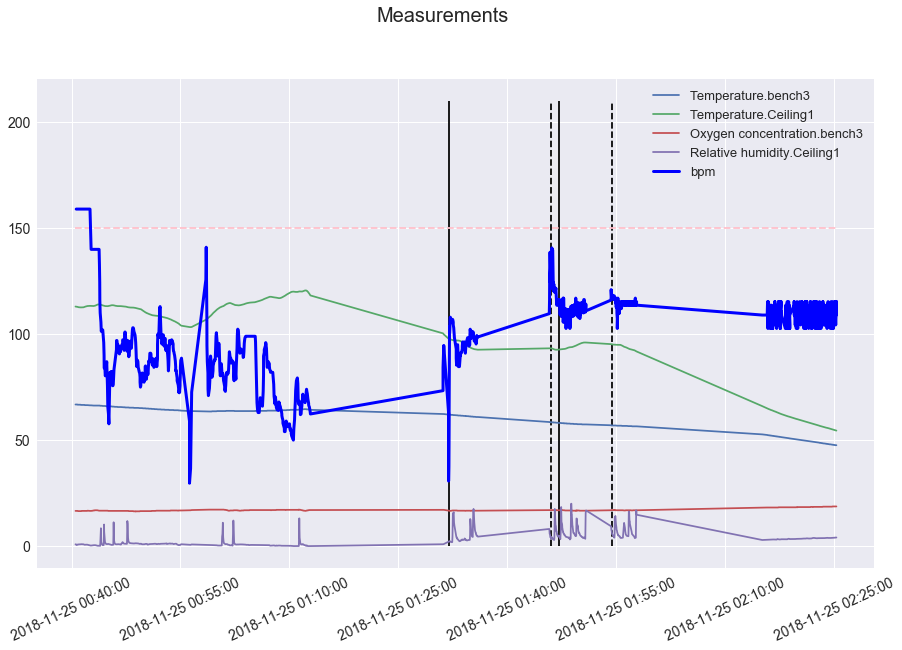

In [940]:
from  datetime import datetime 

ymax = 210
entered = events[(events.event=='ENTERED_SAUNA')&(events.user_id==user_id)].timestamp
left = events[(events.event=='LEFT_SAUNA')&(events.user_id==user_id)].timestamp
good = events[(events.event=='FEEL_GOOD')&(events.user_id==user_id)].timestamp
bad = events[(events.event=='FEEL_BAD')&(events.user_id==user_id)].timestamp

fig, ax1 = plt.subplots(figsize=(15,10))
# ax1 = plt.figure(figsize=(15,8))

dates=[datetime.fromtimestamp(ts) for ts in joined.Timestamp_x/1000]
datenums=md.date2num(dates)

for col in ['Temperature.bench3',
#        'Carbon Dioxide concentration.bench1', 
#             'Temperature.bench1',
#         'Temperature.floor1',
# 'Temperature.bench2',
 'Temperature.Ceiling1', 
            'Oxygen concentration.bench3', 
#        'Carbon Dioxide concentration.bench1', 
#             'Temperature.bench1',
#        'Relative humidity.floor1', 
#        'Relative humidity.bench2', 
       'Relative humidity.Ceiling1'
#             , 'bpm'
           ]:
    values=joined[col]#.rolling(10).mean()
    plt.subplots_adjust(bottom=0.2)
    plt.xticks( rotation=25 )
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(datenums,values)

values=joined['bpm'].rolling(3).mean()
plt.plot(datenums,values, label = 'bpm', linewidth=3, color='blue')


# color = 'tab:blue'
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('CO2', color=color)  # we already handled the x-label with ax1
# ax2.plot(datenums,values, label = 'Carbon Dioxide concentration.bench1', color=color)
# ax2 = joined['Carbon Dioxide concentration.bench1'].plot(secondary_y=True,color=color, ax=ax)

# plt.legend()
# plt.title('Measurements')
plt.legend(prop={'size': 13})
fig.suptitle('Measurements', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
for i in entered:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax)
    
for i in left:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed')
    
for i in good:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'green')    

for i in bad:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'red')    

plt.hlines(150, xmin = datenums.min(), xmax = datenums.max(), linestyles='dashed', color = 'pink', linewidth=1.8)    
    

plt.show()


In [941]:
fig.savefig('test.jpg')

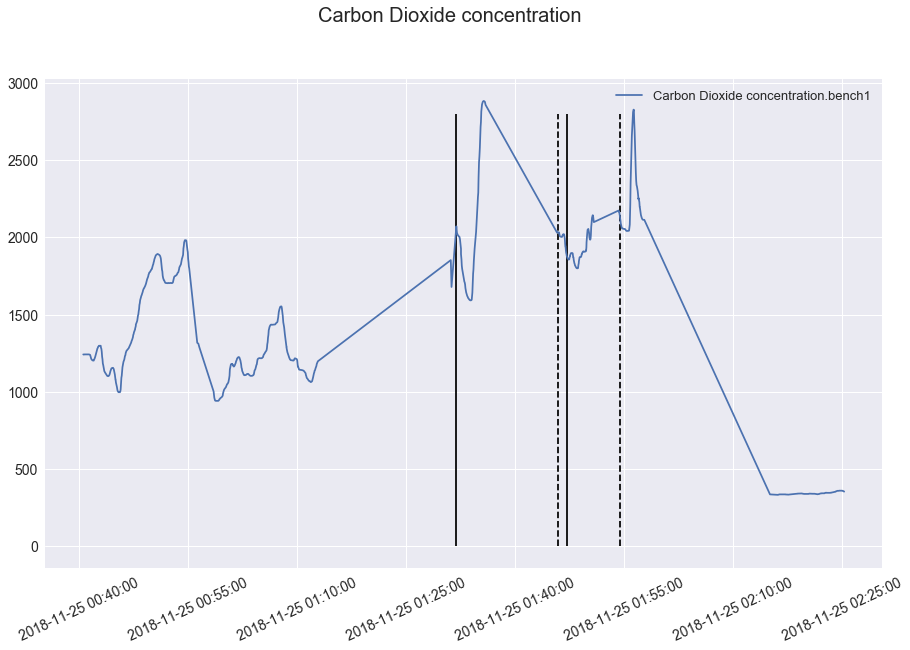

In [939]:
fig, ax1 = plt.subplots(figsize=(15,10))
ymax=2800
dates=[datetime.fromtimestamp(ts) for ts in joined.Timestamp_x/1000]
datenums=md.date2num(dates)

values=joined['Carbon Dioxide concentration.bench1']
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(datenums,values, label='Carbon Dioxide concentration.bench1')

plt.legend(prop={'size': 13})
fig.suptitle('Carbon Dioxide concentration', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.title('Carbon Dioxide concentration')
for i in entered:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax)
    
for i in left:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed')
    
for i in good:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'green')    

for i in bad:
    plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'red')

plt.show()

In [948]:
# fig, ax1 = plt.subplots(figsize=(15,10))
# ymax=2800
# dates=[datetime.fromtimestamp(ts) for ts in joined.Timestamp_x/1000]
# datenums=md.date2num(dates)

# values=joined['bpm'].rolling(3).mean()
# plt.subplots_adjust(bottom=0.2)
# plt.xticks( rotation=25 )
# ax=plt.gca()
# xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
# ax.xaxis.set_major_formatter(xfmt)
# plt.plot(datenums,values, label = 'bpm', linewidth=3, color='blue')

# # values=joined['bpm'].rolling(3).mean()
# # plt.plot(datenums,values, label = 'bpm', linewidth=3, color='blue')

# color = 'tab:blue'
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('CO2', color=color)  # we already handled the x-label with ax1
# ax2.plot(datenums,values, label = 'Carbon Dioxide concentration.bench1', color=color)
# # ax2 = joined['Carbon Dioxide concentration.bench1'].plot(secondary_y=True,color=color, ax=ax)

# plt.legend(prop={'size': 13})
# fig.suptitle('Carbon Dioxide concentration', fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# # plt.title('Carbon Dioxide concentration')
# for i in entered:
#     plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax)
    
# for i in left:
#     plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed')
    
# for i in good:
#     plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'green')    

# for i in bad:
#     plt.vlines(datetime.fromtimestamp(i/1000), ymin=0, ymax=ymax, linestyles='dashed', color = 'red')

# plt.show()